In [39]:
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from modelutils import *
from quant import *


In [25]:


DEBUG = False 

torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


cuda:0


My goal here is to inspect and understand the `SparseGPT` class to understand exactly how are they implementing the Hessians computations discussed in the paper. I'm willing to dissect the class to inspect every relevant variable. The problem is that the scripts that use this class are complex; besides, there are three of them (one for the llama model, one for the opt175m model and one for the bloom model), and they are model-dependent -- in the sense that the scripts depend on the network's architecture. To be able to study this class more efficiently (since it needs a layer as input, so I can't simply run it without a network, or, at the very least, a layer) I'm considering it would be interesting to implement a simplified version of those scripts, one that runs on a network with a less elaborate architecture (and with which I'm more familiarized). Since I'm familiar with the stable diffusion architecture, I'm considering writing a function that prunes one such model in order to compare the generated outputs for equal prompts.

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


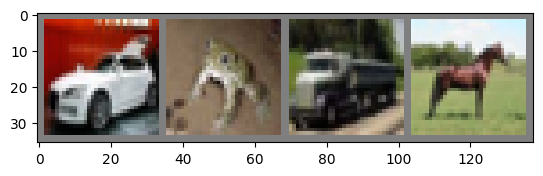

car   frog  truck horse


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.196
[1,  4000] loss: 1.822
[1,  6000] loss: 1.667
[1,  8000] loss: 1.552
[1, 10000] loss: 1.508
[1, 12000] loss: 1.475
[2,  2000] loss: 1.386
[2,  4000] loss: 1.396
[2,  6000] loss: 1.377
[2,  8000] loss: 1.351
[2, 10000] loss: 1.321
[2, 12000] loss: 1.297
Finished Training


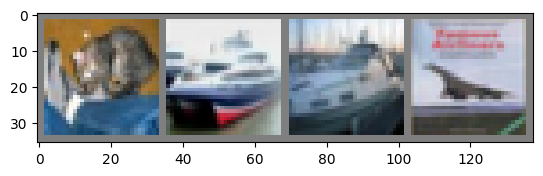

GroundTruth:  cat   ship  ship  plane


In [28]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [29]:
outputs = net(images.to(device))

In [30]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [31]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


In [32]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 62.7 %
Accuracy for class: car   is 65.2 %
Accuracy for class: bird  is 54.7 %
Accuracy for class: cat   is 40.1 %
Accuracy for class: deer  is 31.6 %
Accuracy for class: dog   is 45.8 %
Accuracy for class: frog  is 70.4 %
Accuracy for class: horse is 62.3 %
Accuracy for class: ship  is 58.9 %
Accuracy for class: truck is 56.7 %


In [43]:
modules = list(net.modules())
net1 = modules[0]

In [50]:
layers = list(find_layers(net).values())

In [55]:
layers[0].weight.data.clone();

In [ ]:
@torch.no_grad()
def opt_sequential(model, dataloader, dev):
    print('Starting ...')

    use_cache = model.config.use_cache
    model.config.use_cache = False
    layers = model.model.decoder.layers

    model.model.decoder.embed_tokens = model.model.decoder.embed_tokens.to(dev) 
    model.model.decoder.embed_positions = model.model.decoder.embed_positions.to(dev)
    if hasattr(model.model.decoder, 'project_out') and model.model.decoder.project_out:
        model.model.decoder.project_out = model.model.decoder.project_out.to(dev) 
    if hasattr(model.model.decoder, 'project_in') and model.model.decoder.project_in:
        model.model.decoder.project_in = model.model.decoder.project_in.to(dev) 
    layers[0] = layers[0].to(dev)

    dtype = next(iter(model.parameters())).dtype
    inps = torch.zeros(
        (args.nsamples, model.seqlen, model.config.hidden_size), dtype=dtype, device=dev
    )
    cache = {'i': 0, 'attention_mask': None}

    class Catcher(nn.Module):
        def __init__(self, module):
            super().__init__()
            self.module = module
        def forward(self, inp, **kwargs):
            inps[cache['i']] = inp
            cache['i'] += 1
            cache['attention_mask'] = kwargs['attention_mask']
            raise ValueError
    layers[0] = Catcher(layers[0])
    for batch in dataloader:
        try:
            model(batch[0].to(dev))
        except ValueError:
            pass
    layers[0] = layers[0].module

    layers[0] = layers[0].cpu()
    model.model.decoder.embed_tokens = model.model.decoder.embed_tokens.cpu()
    model.model.decoder.embed_positions = model.model.decoder.embed_positions.cpu()
    if hasattr(model.model.decoder, 'project_out') and model.model.decoder.project_out:
        model.model.decoder.project_out = model.model.decoder.project_out.cpu()
    if hasattr(model.model.decoder, 'project_in') and model.model.decoder.project_in:
        model.model.decoder.project_in = model.model.decoder.project_in.cpu()
    torch.cuda.empty_cache()

    outs = torch.zeros_like(inps)
    attention_mask = cache['attention_mask']

    print('Ready.')

    for i in range(len(layers)):
        layer = layers[i].to(dev)

        subset = find_layers(layer)
        
        gpts = {}
        for name in subset:
            if (not (args.minlayer <= i < args.maxlayer and args.prune_only in name)) == (not args.invert):
              continue
            gpts[name] = SparseGPT(subset[name])
            if args.wbits < 16:
                gpts[name].quantizer = Quantizer()
                gpts[name].quantizer.configure(
                    args.wbits, perchannel=True, sym=False, mse=False
                )

        def add_batch(name):
            def tmp(_, inp, out):
                gpts[name].add_batch(inp[0].data, out.data)
            return tmp
        handles = []
        for name in gpts:
            handles.append(subset[name].register_forward_hook(add_batch(name)))
        for j in range(args.nsamples):
            outs[j] = layer(inps[j].unsqueeze(0), attention_mask=attention_mask)[0]
        for h in handles:
            h.remove()

        for name in gpts:
            print(i, name)
            print('Pruning ...')
            sparsity = args.sparsity
            gpts[name].fasterprune(
                sparsity, prunen=args.prunen, prunem=args.prunem, percdamp=args.percdamp, blocksize=args.blocksize
            )
            gpts[name].free()

        for j in range(args.nsamples):
            outs[j] = layer(inps[j].unsqueeze(0), attention_mask=attention_mask)[0]

        layers[i] = layer.cpu()
        del layer
        torch.cuda.empty_cache()

        inps, outs = outs, inps

    model.config.use_cache = use_cache

In [ ]:

class SparseGPT:

    def __init__(self, layer):
        self.layer = layer
        print(layer)
        print(type(layer))
        self.dev = self.layer.weight.device
        W = layer.weight.data.clone()
        if isinstance(self.layer, nn.Conv2d):
            W = W.flatten(1)
        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        self.rows = W.shape[0]
        self.columns = W.shape[1]
        self.H = torch.zeros((self.columns, self.columns), device=self.dev)
        self.nsamples = 0

    def add_batch(self, inp, out, blocksize=1024):
        if DEBUG:
            self.inp1 = inp
            self.out1 = out
        if len(inp.shape) == 2:
            inp = inp.unsqueeze(0)
        tmp = inp.shape[0]
        if isinstance(self.layer, nn.Linear) or isinstance(self.layer, transformers.Conv1D):
            if len(inp.shape) == 3:
                inp = inp.reshape((-1, inp.shape[-1]))
            inp = inp.t()
        self.H *= self.nsamples / (self.nsamples + tmp)
        self.nsamples += tmp
        inp = math.sqrt(2 / self.nsamples) * inp.float()
        self.H += inp.matmul(inp.t())

    def fasterprune(
        self, sparsity, prunen=0, prunem=0, blocksize=128, percdamp=.01
    ):
        W = self.layer.weight.data.clone()
        if isinstance(self.layer, nn.Conv2d):
            W = W.flatten(1)
        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        W = W.float()

        if hasattr(self, 'quantizer'):
            if not self.quantizer.ready():
                self.quantizer.find_params(W, weight=True)

        tick = time.time()

        H = self.H
        del self.H
        dead = torch.diag(H) == 0
        H[dead, dead] = 1
        W[:, dead] = 0

        Losses = torch.zeros(self.rows, device=self.dev)

        damp = percdamp * torch.mean(torch.diag(H))
        diag = torch.arange(self.columns, device=self.dev)
        H[diag, diag] += damp
        H = torch.linalg.cholesky(H)
        H = torch.cholesky_inverse(H)
        H = torch.linalg.cholesky(H, upper=True)
        Hinv = H

        mask = None

        for i1 in range(0, self.columns, blocksize):
            i2 = min(i1 + blocksize, self.columns)
            count = i2 - i1

            W1 = W[:, i1:i2].clone()
            Q1 = torch.zeros_like(W1)
            Err1 = torch.zeros_like(W1)
            Losses1 = torch.zeros_like(W1)
            Hinv1 = Hinv[i1:i2, i1:i2]

            if prunen == 0: 
                if mask is not None:
                    mask1 = mask[:, i1:i2]
                else:
                    tmp = W1 ** 2 / (torch.diag(Hinv1).reshape((1, -1))) ** 2
                    thresh = torch.sort(tmp.flatten())[0][int(tmp.numel() * sparsity)]
                    mask1 = tmp <= thresh
            else:
                mask1 = torch.zeros_like(W1) == 1

            for i in range(count):
                w = W1[:, i]
                d = Hinv1[i, i]

                if prunen != 0 and i % prunem == 0:
                    tmp = W1[:, i:(i + prunem)] ** 2 / (torch.diag(Hinv1)[i:(i + prunem)].reshape((1, -1))) ** 2
                    mask1.scatter_(1, i + torch.topk(tmp, prunen, dim=1, largest=False)[1], True)

                q = w.clone()
                q[mask1[:, i]] = 0

                if hasattr(self, 'quantizer'):
                    q = quantize(
                        q.unsqueeze(1), self.quantizer.scale, self.quantizer.zero, self.quantizer.maxq
                    ).flatten()

                Q1[:, i] = q
                Losses1[:, i] = (w - q) ** 2 / d ** 2

                err1 = (w - q) / d
                W1[:, i:] -= err1.unsqueeze(1).matmul(Hinv1[i, i:].unsqueeze(0))
                Err1[:, i] = err1

            W[:, i1:i2] = Q1
            Losses += torch.sum(Losses1, 1) / 2

            W[:, i2:] -= Err1.matmul(Hinv[i1:i2, i2:])

            if DEBUG:
                self.layer.weight.data[:, :i2] = W[:, :i2]
                self.layer.weight.data[:, i2:] = W[:, i2:]
                print(torch.sum((self.layer(self.inp1) - self.out1) ** 2))
                print(torch.sum(Losses))

        torch.cuda.synchronize()
        print('time %.2f' % (time.time() - tick))
        print('error', torch.sum(Losses).item())

        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        self.layer.weight.data = W.reshape(self.layer.weight.shape).to(self.layer.weight.data.dtype)
        if DEBUG:
            print(torch.sum((self.layer(self.inp1) - self.out1) ** 2))

    def free(self):
        if DEBUG:
            self.inp1 = None
            self.out1 = None
        self.H = None
        torch.cuda.empty_cache()


In [57]:
w_0 = layers[0].weight.data.clone()

In [75]:
sgpt = SparseGPT(layers[0])

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
<class 'torch.nn.modules.conv.Conv2d'>


In [70]:
sgpt.fasterprune(0.1)

time 0.04
error 0.0


In [71]:
np.alltrue((sgpt.layer.weight.data == 0).cpu().numpy())

True

<generator object Module.modules at 0x0000021AB2C5BA70>